ECS759P Artificial Intelligence: Coursework 2

Logic and Reasoning, Neural Networks and Classification


Renee Mendonca: 22104098

Abstract

The creation, testing, and training of a Convolutional Neural Network (CNN) to distinguish between several articles of clothing are shown in the notebook that follows. The Fashion-MNIST dataset is utilised for training the model. It was discovered that the ultimate train and test accuracy were 97% and 89%, respectively. In addition, several parameters were added or changed to see how the model behaved, such as the learning rate, activation functions, and dropout layers.


Contents

    1. Background 

    2. Imports 

    3. Loading the dataset 

    4. Neural Network 

    5. Evaluation 

    6. Testing 

    7. Visualisation 

1. Background

Convolutional Neural Networks do not employ general matrix multiplication, but rather a mathematical feature called convolution:

Convolutional Neural Networks are a type of Deep Learning [methodology] that can recognise different objects or elements of an input image and distinguish between them by assigning weights and biases that can be learned.



In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pyplot as plt

2. Loading the Dataset

In [2]:
train_set = torchvision.datasets.FashionMNIST(root=".", train=True,
                                              download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root=".", train=False,
                                             download=True, transform=transforms.ToTensor())
training_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                              shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                          shuffle=False)
torch.manual_seed(0)

# If you are using CuDNN , otherwise you can just ignore
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

4. Neural Network

This section details the development of the neural network that corresponds to the following structure:

- 1 input image channel:
   :32 output channels
   :5
×
5 square convolution kernel

- 32 input image channel
     :64 output channels
     :5
×
5 square convolution kernel

- Xavier initialisation for weights

- 2 
×
 fully connected layers
 
- Dropout layer (only used for Task 4)

- Activation function: RELU (default)

In [3]:
# init neural network
class NeuralNetwork(nn.Module):

    def __init__(self,activation_function=F.relu):
        super(NeuralNetwork, self).__init__()
        self.activation_function=activation_function
        # input image channel
        self.conv1 = nn.Conv2d(1, 32, 5)
        # 32 input image channel
        self.conv2 = nn.Conv2d(32, 64, 5)
        
        # xavier initialisation 
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 1024)
        nn.init.xavier_uniform_(self.fc1.weight)
        
        self.fc2 = nn.Linear(1024, 256)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
        nn.init.xavier_uniform_(self.fc3.weight)
        # dropout layer
        #self.dropout = torch.nn.Dropout(0.3) 

    def forward(self, x):
        # max pooling (2x2 window)
        
        x = F.max_pool2d(self.activation_function(self.conv1(x)), (2, 2))
        x = F.max_pool2d(self.activation_function(self.conv2(x)), (2, 2))
        
        # flatten the tensors
        x = x.view(x.size(0), -1)
        
       
        # activation function
        x = self.activation_function(self.fc1(x))
        
        # output 
        x = self.activation_function(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)

        
        # dropout on the 2nd fully connected layer
        # x = self.dropout(self.fc2(x))

        return x

5. Evaluation

This section contains the evaluation method that calculates and returns the accuracy of the trained model.

In [4]:
def evaluation(model, data_loader):
    # initiate model evaluation
    model.eval()
    total, correct = 0, 0
    
    for data in data_loader:
        inputs, label = data
        
        # use google colab gpu if available
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            label = label.cuda()
            
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total = total + label.size(0)
        correct = correct + (pred == label).sum().item()
        # calculate accuracy
        accuracy = 100 * (correct / total)

    return accuracy

6. Testing

This section allows the testing of the CNN with the following learnable parameters:

- Learning rate
- Loss function: Categorical Cross-Entropy Loss
- Optimizer: Stochastic Gradient Descent (SGD)

In [5]:
# init CNN model
model = NeuralNetwork()

# learning rate
learning_rate = 0.1
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 30

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # Move data to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))

Epoch [1/30], Loss: 976.8148, Train Accuracy: 88.25%, Test Accuracy: 87.01%
Epoch [2/30], Loss: 590.6873, Train Accuracy: 90.32%, Test Accuracy: 88.79%
Epoch [3/30], Loss: 501.6703, Train Accuracy: 91.08%, Test Accuracy: 89.35%
Epoch [4/30], Loss: 439.8097, Train Accuracy: 91.83%, Test Accuracy: 89.76%
Epoch [5/30], Loss: 386.6313, Train Accuracy: 91.82%, Test Accuracy: 89.38%
Epoch [6/30], Loss: 340.0141, Train Accuracy: 92.78%, Test Accuracy: 89.70%
Epoch [7/30], Loss: 293.6746, Train Accuracy: 92.76%, Test Accuracy: 89.45%
Epoch [8/30], Loss: 261.1244, Train Accuracy: 93.09%, Test Accuracy: 89.60%
Epoch [9/30], Loss: 238.0307, Train Accuracy: 93.72%, Test Accuracy: 89.66%
Epoch [10/30], Loss: 211.1456, Train Accuracy: 93.68%, Test Accuracy: 89.59%
Epoch [11/30], Loss: 184.6995, Train Accuracy: 93.57%, Test Accuracy: 89.28%
Epoch [12/30], Loss: 173.3900, Train Accuracy: 95.13%, Test Accuracy: 90.18%
Epoch [13/30], Loss: 160.4052, Train Accuracy: 94.95%, Test Accuracy: 89.95%
Epoch [1

7. Visualization

Plots the graphs to view model training.

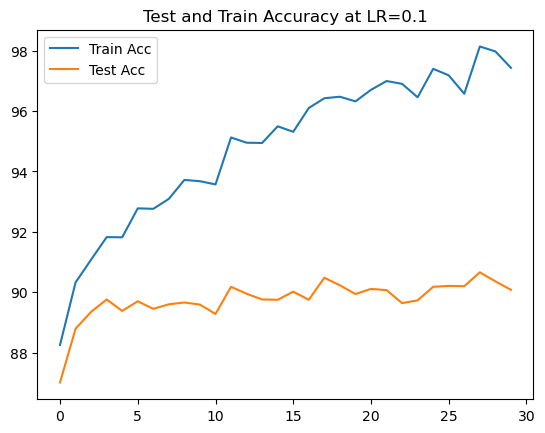

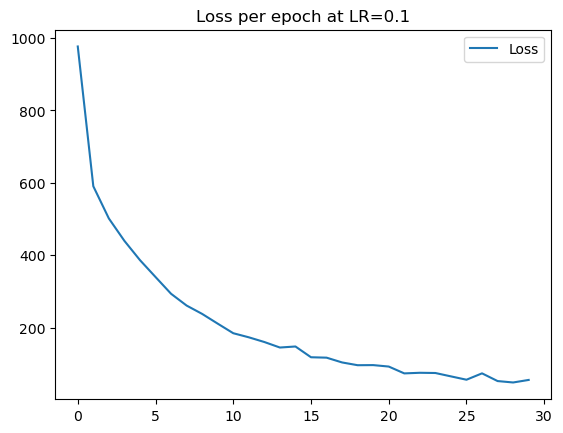

In [6]:
plt.plot(train_accuracy, label="Train Acc")
plt.plot(test_accuracy, label="Test Acc")
plt.title('Test and Train Accuracy at LR={}'.format(learning_rate))
plt.legend()
plt.show()

plt.plot(total_loss, label="Loss")
plt.title('Loss per epoch at LR={}'.format(learning_rate))
plt.legend()
plt.show()

part 3)

run 3 experiments each time changing all the current activation functions to one of the following: Tanh

In [7]:
# init CNN model
model = NeuralNetwork(activation_function=F.tanh)

# learning rate
learning_rate = 0.1
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 30

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # Move data to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))

Epoch [1/30], Loss: 883.3727, Train Accuracy: 88.10%, Test Accuracy: 86.82%
Epoch [2/30], Loss: 598.0828, Train Accuracy: 90.24%, Test Accuracy: 88.61%
Epoch [3/30], Loss: 503.5279, Train Accuracy: 91.41%, Test Accuracy: 89.14%
Epoch [4/30], Loss: 433.2695, Train Accuracy: 92.32%, Test Accuracy: 89.75%
Epoch [5/30], Loss: 372.1019, Train Accuracy: 93.10%, Test Accuracy: 89.92%
Epoch [6/30], Loss: 313.8458, Train Accuracy: 93.50%, Test Accuracy: 89.72%
Epoch [7/30], Loss: 257.9910, Train Accuracy: 94.18%, Test Accuracy: 89.89%
Epoch [8/30], Loss: 207.9337, Train Accuracy: 95.11%, Test Accuracy: 90.24%
Epoch [9/30], Loss: 165.2105, Train Accuracy: 95.29%, Test Accuracy: 89.71%
Epoch [10/30], Loss: 131.8069, Train Accuracy: 96.18%, Test Accuracy: 90.18%
Epoch [11/30], Loss: 117.3537, Train Accuracy: 96.25%, Test Accuracy: 90.14%
Epoch [12/30], Loss: 105.3215, Train Accuracy: 96.66%, Test Accuracy: 90.28%
Epoch [13/30], Loss: 93.2270, Train Accuracy: 96.80%, Test Accuracy: 90.02%
Epoch [14

(ii) run 3 experiments each time changing all the current activation functions to one of the following: Sigmoid

In [8]:
# init CNN model
model = NeuralNetwork(activation_function=F.sigmoid)

# learning rate
learning_rate = 0.1
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 30

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # Move data to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))

Epoch [1/30], Loss: 4339.7929, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [2/30], Loss: 4289.6347, Train Accuracy: 26.26%, Test Accuracy: 26.14%
Epoch [3/30], Loss: 1994.8192, Train Accuracy: 71.64%, Test Accuracy: 71.26%
Epoch [4/30], Loss: 1368.8795, Train Accuracy: 74.54%, Test Accuracy: 73.87%
Epoch [5/30], Loss: 1209.0794, Train Accuracy: 76.63%, Test Accuracy: 75.84%
Epoch [6/30], Loss: 1103.4584, Train Accuracy: 78.65%, Test Accuracy: 77.76%
Epoch [7/30], Loss: 1015.0393, Train Accuracy: 80.55%, Test Accuracy: 79.39%
Epoch [8/30], Loss: 944.0558, Train Accuracy: 82.49%, Test Accuracy: 81.34%
Epoch [9/30], Loss: 886.1862, Train Accuracy: 83.67%, Test Accuracy: 82.58%
Epoch [10/30], Loss: 836.2837, Train Accuracy: 84.58%, Test Accuracy: 83.54%
Epoch [11/30], Loss: 792.4703, Train Accuracy: 85.20%, Test Accuracy: 84.20%
Epoch [12/30], Loss: 754.7186, Train Accuracy: 85.81%, Test Accuracy: 84.83%
Epoch [13/30], Loss: 722.7394, Train Accuracy: 86.30%, Test Accuracy: 85.32%
E

(iii) run 3 experiments each time changing all the current activation functions to one of the following: ELU

In [9]:
# init CNN model
model = NeuralNetwork(activation_function=F.elu)

# learning rate
learning_rate = 0.1
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 30

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # Move data to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))

Epoch [1/30], Loss: 871.1318, Train Accuracy: 87.89%, Test Accuracy: 86.60%
Epoch [2/30], Loss: 590.8650, Train Accuracy: 90.16%, Test Accuracy: 88.52%
Epoch [3/30], Loss: 504.2920, Train Accuracy: 91.07%, Test Accuracy: 89.03%
Epoch [4/30], Loss: 442.2312, Train Accuracy: 91.73%, Test Accuracy: 89.22%
Epoch [5/30], Loss: 389.2219, Train Accuracy: 92.59%, Test Accuracy: 89.46%
Epoch [6/30], Loss: 340.7712, Train Accuracy: 93.64%, Test Accuracy: 89.80%
Epoch [7/30], Loss: 299.7989, Train Accuracy: 93.80%, Test Accuracy: 89.61%
Epoch [8/30], Loss: 260.5645, Train Accuracy: 94.27%, Test Accuracy: 89.43%
Epoch [9/30], Loss: 232.0709, Train Accuracy: 94.65%, Test Accuracy: 89.59%
Epoch [10/30], Loss: 219.5608, Train Accuracy: 94.71%, Test Accuracy: 89.46%
Epoch [11/30], Loss: 206.8519, Train Accuracy: 94.72%, Test Accuracy: 89.16%
Epoch [12/30], Loss: 189.3640, Train Accuracy: 95.73%, Test Accuracy: 90.38%
Epoch [13/30], Loss: 168.8165, Train Accuracy: 95.63%, Test Accuracy: 89.40%
Epoch [1

Keeping ReLU using 5 diff learning rates: 0.001

In [10]:
# total loss 
total_loss_results = []
# training accuracy 
train_accuracy_results = []
# testing accuracy 
test_accuracy_results = []

In [11]:
# init CNN model
model = NeuralNetwork()

# learning rate
learning_rate = 0.001
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 30

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # Move data to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))
# total loss 
total_loss_results.append(sum(loss_list))
# training accuracy 
train_accuracy_results.append(train_acc)
# testing accuracy 
test_accuracy_results.append(test_acc) 

Epoch [1/30], Loss: 3230.5772, Train Accuracy: 68.83%, Test Accuracy: 68.53%
Epoch [2/30], Loss: 1540.0949, Train Accuracy: 72.70%, Test Accuracy: 72.12%
Epoch [3/30], Loss: 1345.3975, Train Accuracy: 75.18%, Test Accuracy: 74.54%
Epoch [4/30], Loss: 1248.2362, Train Accuracy: 76.98%, Test Accuracy: 76.33%
Epoch [5/30], Loss: 1178.7828, Train Accuracy: 78.41%, Test Accuracy: 77.42%
Epoch [6/30], Loss: 1123.0353, Train Accuracy: 79.42%, Test Accuracy: 78.54%
Epoch [7/30], Loss: 1075.4785, Train Accuracy: 80.28%, Test Accuracy: 79.50%
Epoch [8/30], Loss: 1034.5778, Train Accuracy: 81.11%, Test Accuracy: 80.23%
Epoch [9/30], Loss: 998.7575, Train Accuracy: 81.86%, Test Accuracy: 81.05%
Epoch [10/30], Loss: 966.7408, Train Accuracy: 82.50%, Test Accuracy: 81.36%
Epoch [11/30], Loss: 938.2454, Train Accuracy: 83.06%, Test Accuracy: 82.12%
Epoch [12/30], Loss: 912.9127, Train Accuracy: 83.47%, Test Accuracy: 82.51%
Epoch [13/30], Loss: 890.3614, Train Accuracy: 83.92%, Test Accuracy: 82.92%


Keeping ReLU using 5 diff learning rates: 0.1

In [12]:
# init CNN model
model = NeuralNetwork()

# learning rate
learning_rate = 0.1
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 30

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # Move data to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))
# total loss 
total_loss_results.append(sum(loss_list))
# training accuracy 
train_accuracy_results.append(train_acc)
# testing accuracy 
test_accuracy_results.append(test_acc) 

Epoch [1/30], Loss: 1001.3749, Train Accuracy: 86.93%, Test Accuracy: 85.73%
Epoch [2/30], Loss: 608.1828, Train Accuracy: 89.37%, Test Accuracy: 87.97%
Epoch [3/30], Loss: 515.3957, Train Accuracy: 90.53%, Test Accuracy: 88.89%
Epoch [4/30], Loss: 453.0095, Train Accuracy: 91.23%, Test Accuracy: 89.12%
Epoch [5/30], Loss: 399.6933, Train Accuracy: 91.89%, Test Accuracy: 89.44%
Epoch [6/30], Loss: 348.3337, Train Accuracy: 92.03%, Test Accuracy: 89.17%
Epoch [7/30], Loss: 305.8396, Train Accuracy: 92.75%, Test Accuracy: 89.48%
Epoch [8/30], Loss: 269.1591, Train Accuracy: 92.82%, Test Accuracy: 89.42%
Epoch [9/30], Loss: 238.1901, Train Accuracy: 93.06%, Test Accuracy: 88.67%
Epoch [10/30], Loss: 221.3392, Train Accuracy: 92.84%, Test Accuracy: 88.63%
Epoch [11/30], Loss: 201.3530, Train Accuracy: 93.37%, Test Accuracy: 89.11%
Epoch [12/30], Loss: 182.1328, Train Accuracy: 94.80%, Test Accuracy: 89.73%
Epoch [13/30], Loss: 164.5699, Train Accuracy: 94.26%, Test Accuracy: 88.83%
Epoch [

Keeping ReLU using 5 diff learning rates: 0.5

In [13]:
# init CNN model
model = NeuralNetwork()

# learning rate
learning_rate = 0.5
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 30

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # Move data to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))
# total loss 
total_loss_results.append(sum(loss_list))
# training accuracy 
train_accuracy_results.append(train_acc)
# testing accuracy 
test_accuracy_results.append(test_acc) 

Epoch [1/30], Loss: 1214.0679, Train Accuracy: 85.87%, Test Accuracy: 84.82%
Epoch [2/30], Loss: 746.7271, Train Accuracy: 86.56%, Test Accuracy: 85.18%
Epoch [3/30], Loss: 653.0057, Train Accuracy: 87.59%, Test Accuracy: 86.20%
Epoch [4/30], Loss: 615.4583, Train Accuracy: 86.28%, Test Accuracy: 84.97%
Epoch [5/30], Loss: 577.4785, Train Accuracy: 88.02%, Test Accuracy: 86.08%
Epoch [6/30], Loss: 552.8590, Train Accuracy: 86.47%, Test Accuracy: 84.31%
Epoch [7/30], Loss: 532.1981, Train Accuracy: 88.90%, Test Accuracy: 86.05%
Epoch [8/30], Loss: 518.4987, Train Accuracy: 88.41%, Test Accuracy: 85.67%
Epoch [9/30], Loss: 497.6844, Train Accuracy: 89.77%, Test Accuracy: 86.43%
Epoch [10/30], Loss: 616.8547, Train Accuracy: 88.46%, Test Accuracy: 85.66%
Epoch [11/30], Loss: 509.6059, Train Accuracy: 87.39%, Test Accuracy: 84.27%
Epoch [12/30], Loss: 499.6725, Train Accuracy: 86.03%, Test Accuracy: 82.95%
Epoch [13/30], Loss: 521.8676, Train Accuracy: 88.88%, Test Accuracy: 85.26%
Epoch [

Keeping ReLU using 5 diff learning rates: 1

In [14]:
# init CNN model
model = NeuralNetwork()

# learning rate
learning_rate = 1
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 30

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # Move data to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))
# total loss 
total_loss_results.append(sum(loss_list))
# training accuracy 
train_accuracy_results.append(train_acc)
# testing accuracy 
test_accuracy_results.append(test_acc) 

Epoch [1/30], Loss: 4339.6333, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [2/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [3/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [4/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [5/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [6/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [7/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [8/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [9/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [10/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [11/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [12/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [13/30], Loss: 4330.5616, Train Accuracy: 10.00%, Test Accuracy: 10

Keeping ReLU using 5 diff learning rates: 10

In [15]:
# init CNN model
model = NeuralNetwork()

# learning rate
learning_rate = 10
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 30

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # Move data to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))
# total loss 
total_loss_results.append(sum(loss_list))
# training accuracy 
train_accuracy_results.append(train_acc)
# testing accuracy 
test_accuracy_results.append(test_acc) 

Epoch [1/30], Loss: 200222045291404591104.0000, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [2/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [3/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [4/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [5/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [6/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [7/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [8/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [9/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [10/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [11/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [12/30], Loss: 4636.2253, Train Accuracy: 10.00%, Test Accuracy: 10.00%
Epoch [13/30], Loss: 4636.2253, Train Accuracy: 10.00%, 

In [16]:
pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.


In [17]:
import tabulate

headers = ["Learning Rate", "Final Train Loss", "Final Train Accuracy", "Final Test Accuracy"]
data = [[0.001,total_loss_results[0], train_accuracy_results[0], test_accuracy_results[0]], 
       [0.1,total_loss_results[1], train_accuracy_results[1], test_accuracy_results[1]],
       [0.5,total_loss_results[2], train_accuracy_results[2], test_accuracy_results[2]],
       [1,total_loss_results[3], train_accuracy_results[3], test_accuracy_results[3]],
       [10,total_loss_results[4], train_accuracy_results[4], test_accuracy_results[4]]]
grid=tabulate.tabulate(data, headers=headers, tablefmt='html')
grid

Learning Rate,Final Train Loss,Final Train Accuracy,Final Test Accuracy
0.001,679.401,87.5233,86.2
0.1,62.7647,97.6083,90.09
0.5,nan,10,10
1,4330.56,10,10
10,4636.23,10,10


In [18]:
print(f"Learning Rate = 0.001, Final Train Loss = {total_loss_results[0]}, Final Train Accuracy = {train_accuracy_results[0]}, Final Test Accuracy= {test_accuracy_results[0]}")
print(f"Learning Rate = 0.1, Final Train Loss = {total_loss_results[1]}, Final Train Accuracy = {train_accuracy_results[1]}, Final Test Accuracy= {test_accuracy_results[1]}")
print(f"Learning Rate = 0.5, Final Train Loss = {total_loss_results[2]}, Final Train Accuracy = {train_accuracy_results[2]}, Final Test Accuracy= {test_accuracy_results[2]}")
print(f"Learning Rate = 1, Final Train Loss = {total_loss_results[3]}, Final Train Accuracy = {train_accuracy_results[3]}, Final Test Accuracy= {test_accuracy_results[3]}")
print(f"Learning Rate = 10, Final Train Loss = {total_loss_results[4]}, Final Train Accuracy = {train_accuracy_results[4]}, Final Test Accuracy= {test_accuracy_results[4]}")


Learning Rate = 0.001, Final Train Loss = 679.4006844833493, Final Train Accuracy = 87.52333333333333, Final Test Accuracy= 86.2
Learning Rate = 0.1, Final Train Loss = 62.76471554749514, Final Train Accuracy = 97.60833333333333, Final Test Accuracy= 90.09
Learning Rate = 0.5, Final Train Loss = nan, Final Train Accuracy = 10.0, Final Test Accuracy= 10.0
Learning Rate = 1, Final Train Loss = 4330.561626911163, Final Train Accuracy = 10.0, Final Test Accuracy= 10.0
Learning Rate = 10, Final Train Loss = 4636.225276231766, Final Train Accuracy = 10.0, Final Test Accuracy= 10.0


Dropout

In [19]:
# init neural network
class NeuralNetwork(nn.Module):
    

    def __init__(self,activation_function=F.relu):
        super(NeuralNetwork, self).__init__()
        self.activation_function=activation_function
        # input image channel
        self.conv1 = nn.Conv2d(1, 32, 5)
        # 32 input image channel
        self.conv2 = nn.Conv2d(32, 64, 5)
        
        # xavier initialisation 
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        
        # fully connected second layer
        
        self.fc1 = nn.Linear(64 * 4 * 4, 1024)
        nn.init.xavier_uniform_(self.fc1.weight)
        
        self.fc2 = nn.Linear(1024, 256)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
        nn.init.xavier_uniform_(self.fc3.weight)
        
        # dropout layer
        self.dropout = torch.nn.Dropout(0.3) 

    def forward(self, x):
        # max pooling (2x2 window)
        
        x = F.max_pool2d(self.activation_function(self.conv1(x)), (2, 2))
        x = F.max_pool2d(self.activation_function(self.conv2(x)), (2, 2))
        
        # flatten the tensors
        x = x.view(x.size(0), -1)
        
       
        # # activation function
        x = self.activation_function(self.fc1(x))
        
        # output 
        x = self.activation_function(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        
        # dropout on the 2nd fully connected layer
        # x = self.dropout(self.fc2(x))

        return x

In [20]:
# init CNN model
model = NeuralNetwork()

# learning rate
learning_rate = 0.1
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# total loss 
total_loss = []
# training accuracy 
train_accuracy = []
# testing accuracy 
test_accuracy = []

# epochs
num_epochs = 30

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):
    # loss (batches)
    loss_list = []
    for i, (images, labels) in enumerate(training_loader):
        # train
        model.train()
        
        # Move data to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        # forward pass
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # append loss to loss in batches
        loss_list.append(loss.item())

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation 
        loss.backward()
        
        # SGD optimisation
        optimizer.step()

    # training accuracy
    train_acc = evaluation(model, training_loader)
    train_accuracy.append(train_acc)
    
    # testing accuracy
    test_acc = evaluation(model, test_loader)
    test_accuracy.append(test_acc)
    
    # store total loss
    total_loss.append(sum(loss_list))
    
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, sum(loss_list), train_acc, test_acc))

Epoch [1/30], Loss: 1027.7140, Train Accuracy: 87.27%, Test Accuracy: 86.12%
Epoch [2/30], Loss: 620.3441, Train Accuracy: 89.20%, Test Accuracy: 88.02%
Epoch [3/30], Loss: 529.0556, Train Accuracy: 91.17%, Test Accuracy: 89.46%
Epoch [4/30], Loss: 471.2866, Train Accuracy: 91.53%, Test Accuracy: 89.35%
Epoch [5/30], Loss: 423.3582, Train Accuracy: 92.43%, Test Accuracy: 89.94%
Epoch [6/30], Loss: 381.0764, Train Accuracy: 92.96%, Test Accuracy: 90.23%
Epoch [7/30], Loss: 339.5425, Train Accuracy: 93.57%, Test Accuracy: 90.62%
Epoch [8/30], Loss: 304.4786, Train Accuracy: 93.10%, Test Accuracy: 89.91%
Epoch [9/30], Loss: 275.3624, Train Accuracy: 94.08%, Test Accuracy: 90.30%
Epoch [10/30], Loss: 249.2363, Train Accuracy: 93.91%, Test Accuracy: 89.87%
Epoch [11/30], Loss: 225.8014, Train Accuracy: 95.07%, Test Accuracy: 90.46%
Epoch [12/30], Loss: 210.6173, Train Accuracy: 94.81%, Test Accuracy: 90.20%
Epoch [13/30], Loss: 183.0786, Train Accuracy: 94.93%, Test Accuracy: 90.15%
Epoch [